***
<a name='data'>

# 1 <span style='color:darkcyan'>|</span> About the Data

**Introduction**

This dataset consists of four classes of brain tumors: pituitary, glioma, meningioma, and normal. The dataset was created by cleaning the brain tumor classification MRI dataset, which can be accessed at this link. The cleaning process involved removing duplicate samples, correcting mislabeled images, and resizing all images to a size of (224, 224).

**Types of Brain Tumors**

* **Pituitary tumor:** A tumor that grows in the pituitary gland, which is a small gland at the base of the brain. Pituitary tumors can be benign or malignant.
* **Glioma:** A tumor that grows in the glial cells, which are the supportive cells of the brain. Gliomas are the most common type of brain tumor.
* **Meningioma:** A tumor that grows in the meninges, which are the membranes that surround the brain and spinal cord. Meningiomas are usually benign, but they can sometimes be malignant.
* **Normal:** A brain scan that does not show any signs of a tumor.

**Data Cleaning Process**

The data cleaning process involved the following steps:

1. Removal of duplicate samples: This was done by using an image vector comparison method.
2. Correction of mislabeled images: This was done by carefully inspecting the images and correcting any labels that were incorrect.
3. Image resizing: All images were resized to a size of (224, 224).

**Data Augmentation**

To enhance the diversity and robustness of the dataset, various image augmentation techniques were used. These techniques were applied to the images without altering the labels. The following augmentation methods were used:

* Salt and pepper noise: This introduces random noise by setting pixels to white or black based on a specified intensity.
* Histogram equalization: This enhances the contrast and details in the images.
* Rotation: This rotates the images clockwise or counterclockwise by a specified angle.
* Brightness adjustment: This modifies the brightness of the images by adding or subtracting intensity values.
* Horizontal and vertical flipping: This flips the images horizontally or vertically to create mirror images.

**Use Cases and Potential Investigations**

This dataset can be used for a variety of advanced medical research and analysis applications. Some potential use cases include:

* Tumor classification: This could involve developing advanced machine learning models for accurate and automated brain tumor classification.
* Treatment planning: This could involve analyzing the tumor characteristics to aid in treatment planning and decision-making processes.
* Radiomics analysis: This could involve extracting quantitative features from the images for radiomics analysis to uncover valuable insights and patterns.
* Comparative studies: This could involve conducting comparative studies among different tumor types to understand their unique characteristics and behaviors.

**Acknowledgment**

We would like to express our sincere gratitude to the original dataset publisher, sartajbhuvaji, for their valuable contribution.

**License**

This dataset is released under the CC0 license, making it open and accessible for everyone to use. While not mandatory, citing the dataset would be greatly appreciated.

**Important Note**

Those researchers who want to use this dataset for real-world use cases must consult with medical field experts (radiologists, etc.) on the ground truth of the labels and their usability for their angle of research.

<a name='imports'>

# 2 <span style='color:darkcyan'>|</span> Importing & Setup

In [9]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [10]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})


***
<a name='import_data'>
    
# 3 <span style='color:darkcyan'>|</span> Importing Data

In [11]:
# Function for inporting data           
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return data_path, data_labels

In [12]:
# Setting up file paths for training and testing
USER_PATH = r"/kaggle/input/brain-tumors-dataset/Data"
normal = USER_PATH + r'/'
tumor = USER_PATH + r'/Tumor'

# Getting data using above function
normal_paths, normal_labels = get_data_labels(normal, shuffle=False)
tumor_paths, tumor_labels = get_data_labels(tumor, shuffle=False)

# Printing Normal and tumor sample sizes
print('Normal Brain Scans')
print(f'Number of Paths: {len(normal_paths)}')
print(f'Number of Labels: {len(normal_labels)}')
print('\nTumor Brain Scans')
print(f'Number of Paths: {len(tumor_paths)}')
print(f'Number of Labels: {len(tumor_labels)}')

Normal Brain Scans
Number of Paths: 3069
Number of Labels: 3069

Tumor Brain Scans
Number of Paths: 18606
Number of Labels: 18606


In [13]:
print(f'Some Tumor labels: {tumor_labels[500:505]}')

# Remove the word "tumor" from each element in the list
tumor_labels = [path.replace('_tumor', '').title() for path in tumor_labels]

# Print the cleaned paths
print(f'Some Tumor labels: {tumor_labels[500:505]}')

Some Tumor labels: ['pituitary_tumor', 'pituitary_tumor', 'glioma_tumor', 'glioma_tumor', 'pituitary_tumor']
Some Tumor labels: ['Pituitary', 'Pituitary', 'Glioma', 'Glioma', 'Pituitary']


***
<a name='DP'>
    
# 4 <span style='color:darkcyan'>|</span> Data Processing

In [14]:
from sklearn.model_selection import train_test_split

# Merging paths and labels
MRI_paths = normal_paths + tumor_paths
MRI_labels = normal_labels + tumor_labels

# Split the data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    MRI_paths, MRI_labels, test_size=0.35, random_state=SEED
)

# Create DataFrames for training and testing data
train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
test_df = pd.DataFrame({'path': test_paths, 'label': test_labels})

In [15]:
# 2 values in train_df and 1 in test_df have a un-defined tumor value
train_df = train_df[train_df['label'] != 'Tumor']
test_df = test_df[test_df['label'] != 'Tumor']


In [16]:
CLASS_TYPES = pd.unique(train_df['label'])
N_TYPES = len(CLASS_TYPES)

print(f'Classes: {CLASS_TYPES} and length {N_TYPES}')

Classes: ['Normal' 'Meningioma' 'Glioma' 'Pituitary'] and length 4


In [17]:
# Mapping dictionary
tumor_classes = {'Normal': 0,
                 'Glioma': 1,
                 'Meningioma': 2,
                 'Pituitary': 3
}


# Apply mapping to both DataFrames
train_df['label_encoded'] = train_df['label'].map(tumor_classes)
test_df['label_encoded'] = test_df['label'].map(tumor_classes)


In [18]:
display(train_df)
display(test_df)

path       label  \
0      /kaggle/input/brain-tumors-dataset/Data/Normal...      Normal   
1      /kaggle/input/brain-tumors-dataset/Data/Tumor/...  Meningioma   
2      /kaggle/input/brain-tumors-dataset/Data/Tumor/...      Glioma   
3      /kaggle/input/brain-tumors-dataset/Data/Tumor/...   Pituitary   
4      /kaggle/input/brain-tumors-dataset/Data/Tumor/...   Pituitary   
...                                                  ...         ...   
14083  /kaggle/input/brain-tumors-dataset/Data/Tumor/...      Glioma   
14084  /kaggle/input/brain-tumors-dataset/Data/Tumor/...  Meningioma   
14085  /kaggle/input/brain-tumors-dataset/Data/Tumor/...      Glioma   
14086  /kaggle/input/brain-tumors-dataset/Data/Tumor/...      Glioma   
14087  /kaggle/input/brain-tumors-dataset/Data/Tumor/...      Glioma   

       label_encoded  
0                  0  
1                  2  
2                  1  
3                  3  
4                  3  
...              ...  
14083              1  
14084              2  
14085              1  
14086              1  
14087              1  

[14087 rows x 3 columns]

path       label  \
0     /kaggle/input/brain-tumors-dataset/Data/Tumor/...      Glioma   
1     /kaggle/input/brain-tumors-dataset/Data/Tumor/...  Meningioma   
2     /kaggle/input/brain-tumors-dataset/Data/Tumor/...  Meningioma   
3     /kaggle/input/brain-tumors-dataset/Data/Tumor/...      Glioma   
4     /kaggle/input/brain-tumors-dataset/Data/Tumor/...      Glioma   
...                                                 ...         ...   
7582  /kaggle/input/brain-tumors-dataset/Data/Tumor/...   Pituitary   
7583  /kaggle/input/brain-tumors-dataset/Data/Tumor/...  Meningioma   
7584  /kaggle/input/brain-tumors-dataset/Data/Normal...      Normal   
7585  /kaggle/input/brain-tumors-dataset/Data/Tumor/...      Glioma   
7586  /kaggle/input/brain-tumors-dataset/Data/Tumor/...   Pituitary   

      label_encoded  
0                 1  
1                 2  
2                 2  
3                 1  
4                 1  
...             ...  
7582              3  
7583              2  
7584              0  
7585              1  
7586              3  

[7585 rows x 3 columns]

Training Counts
{'Normal': 2004, 'Meningioma': 4149, 'Glioma': 4131, 'Pituitary': 3803}

Testing Counts
{'Normal': 1062, 'Meningioma': 2242, 'Glioma': 2176, 'Pituitary': 2105}


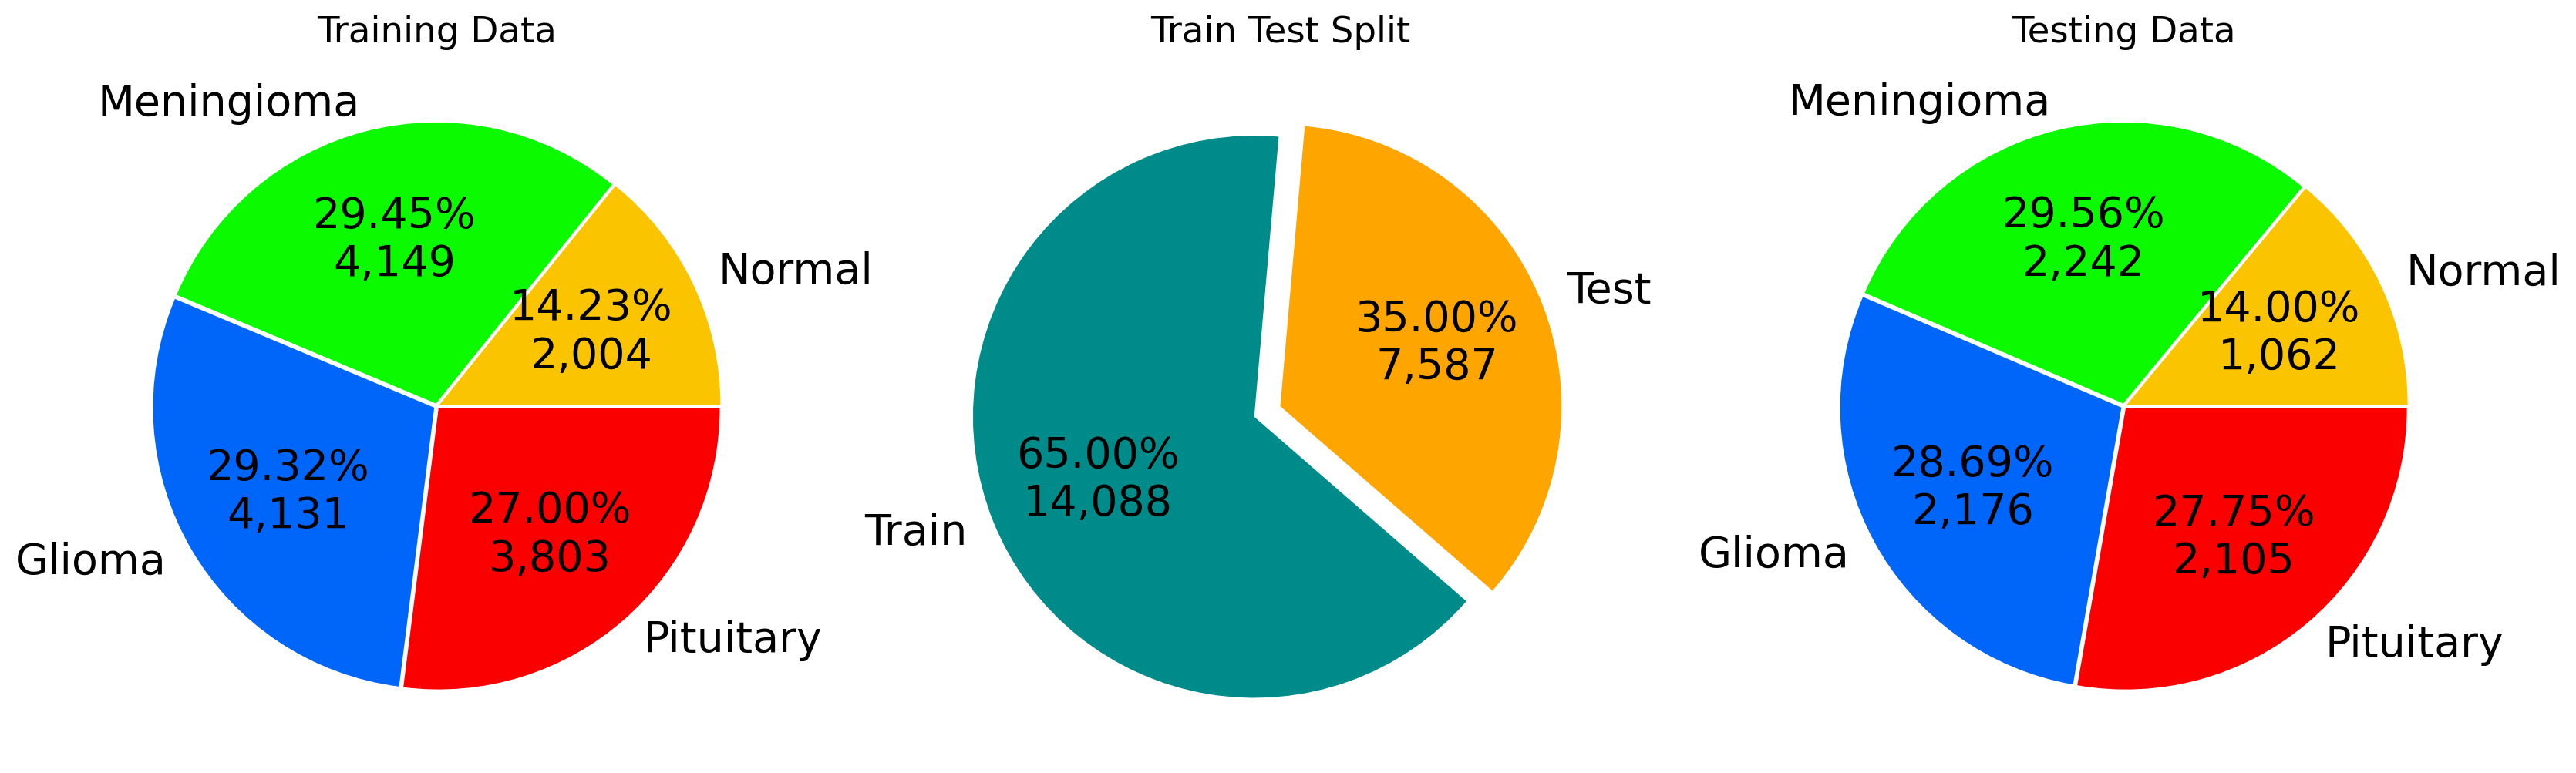

In [19]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
print('Training Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=CLASS_TYPES,
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_labels), len(test_labels)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_labels), len(test_labels)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
print('\nTesting Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=CLASS_TYPES,
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),  # Explode the slices slightly for better visualization
    textprops={'fontsize': 20}  # Set the font size for the text on the pie chart
)


plt.show()


***
<a name='vis'>
    
# 5 <span style='color:darkcyan'>|</span> Data Visualization

x reshaped: (1, 150, 150, 3)


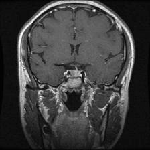

In [20]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [21]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        
        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths[index]}')
        ax[i].axis('off')

    plt.tight_layout()
    
    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()

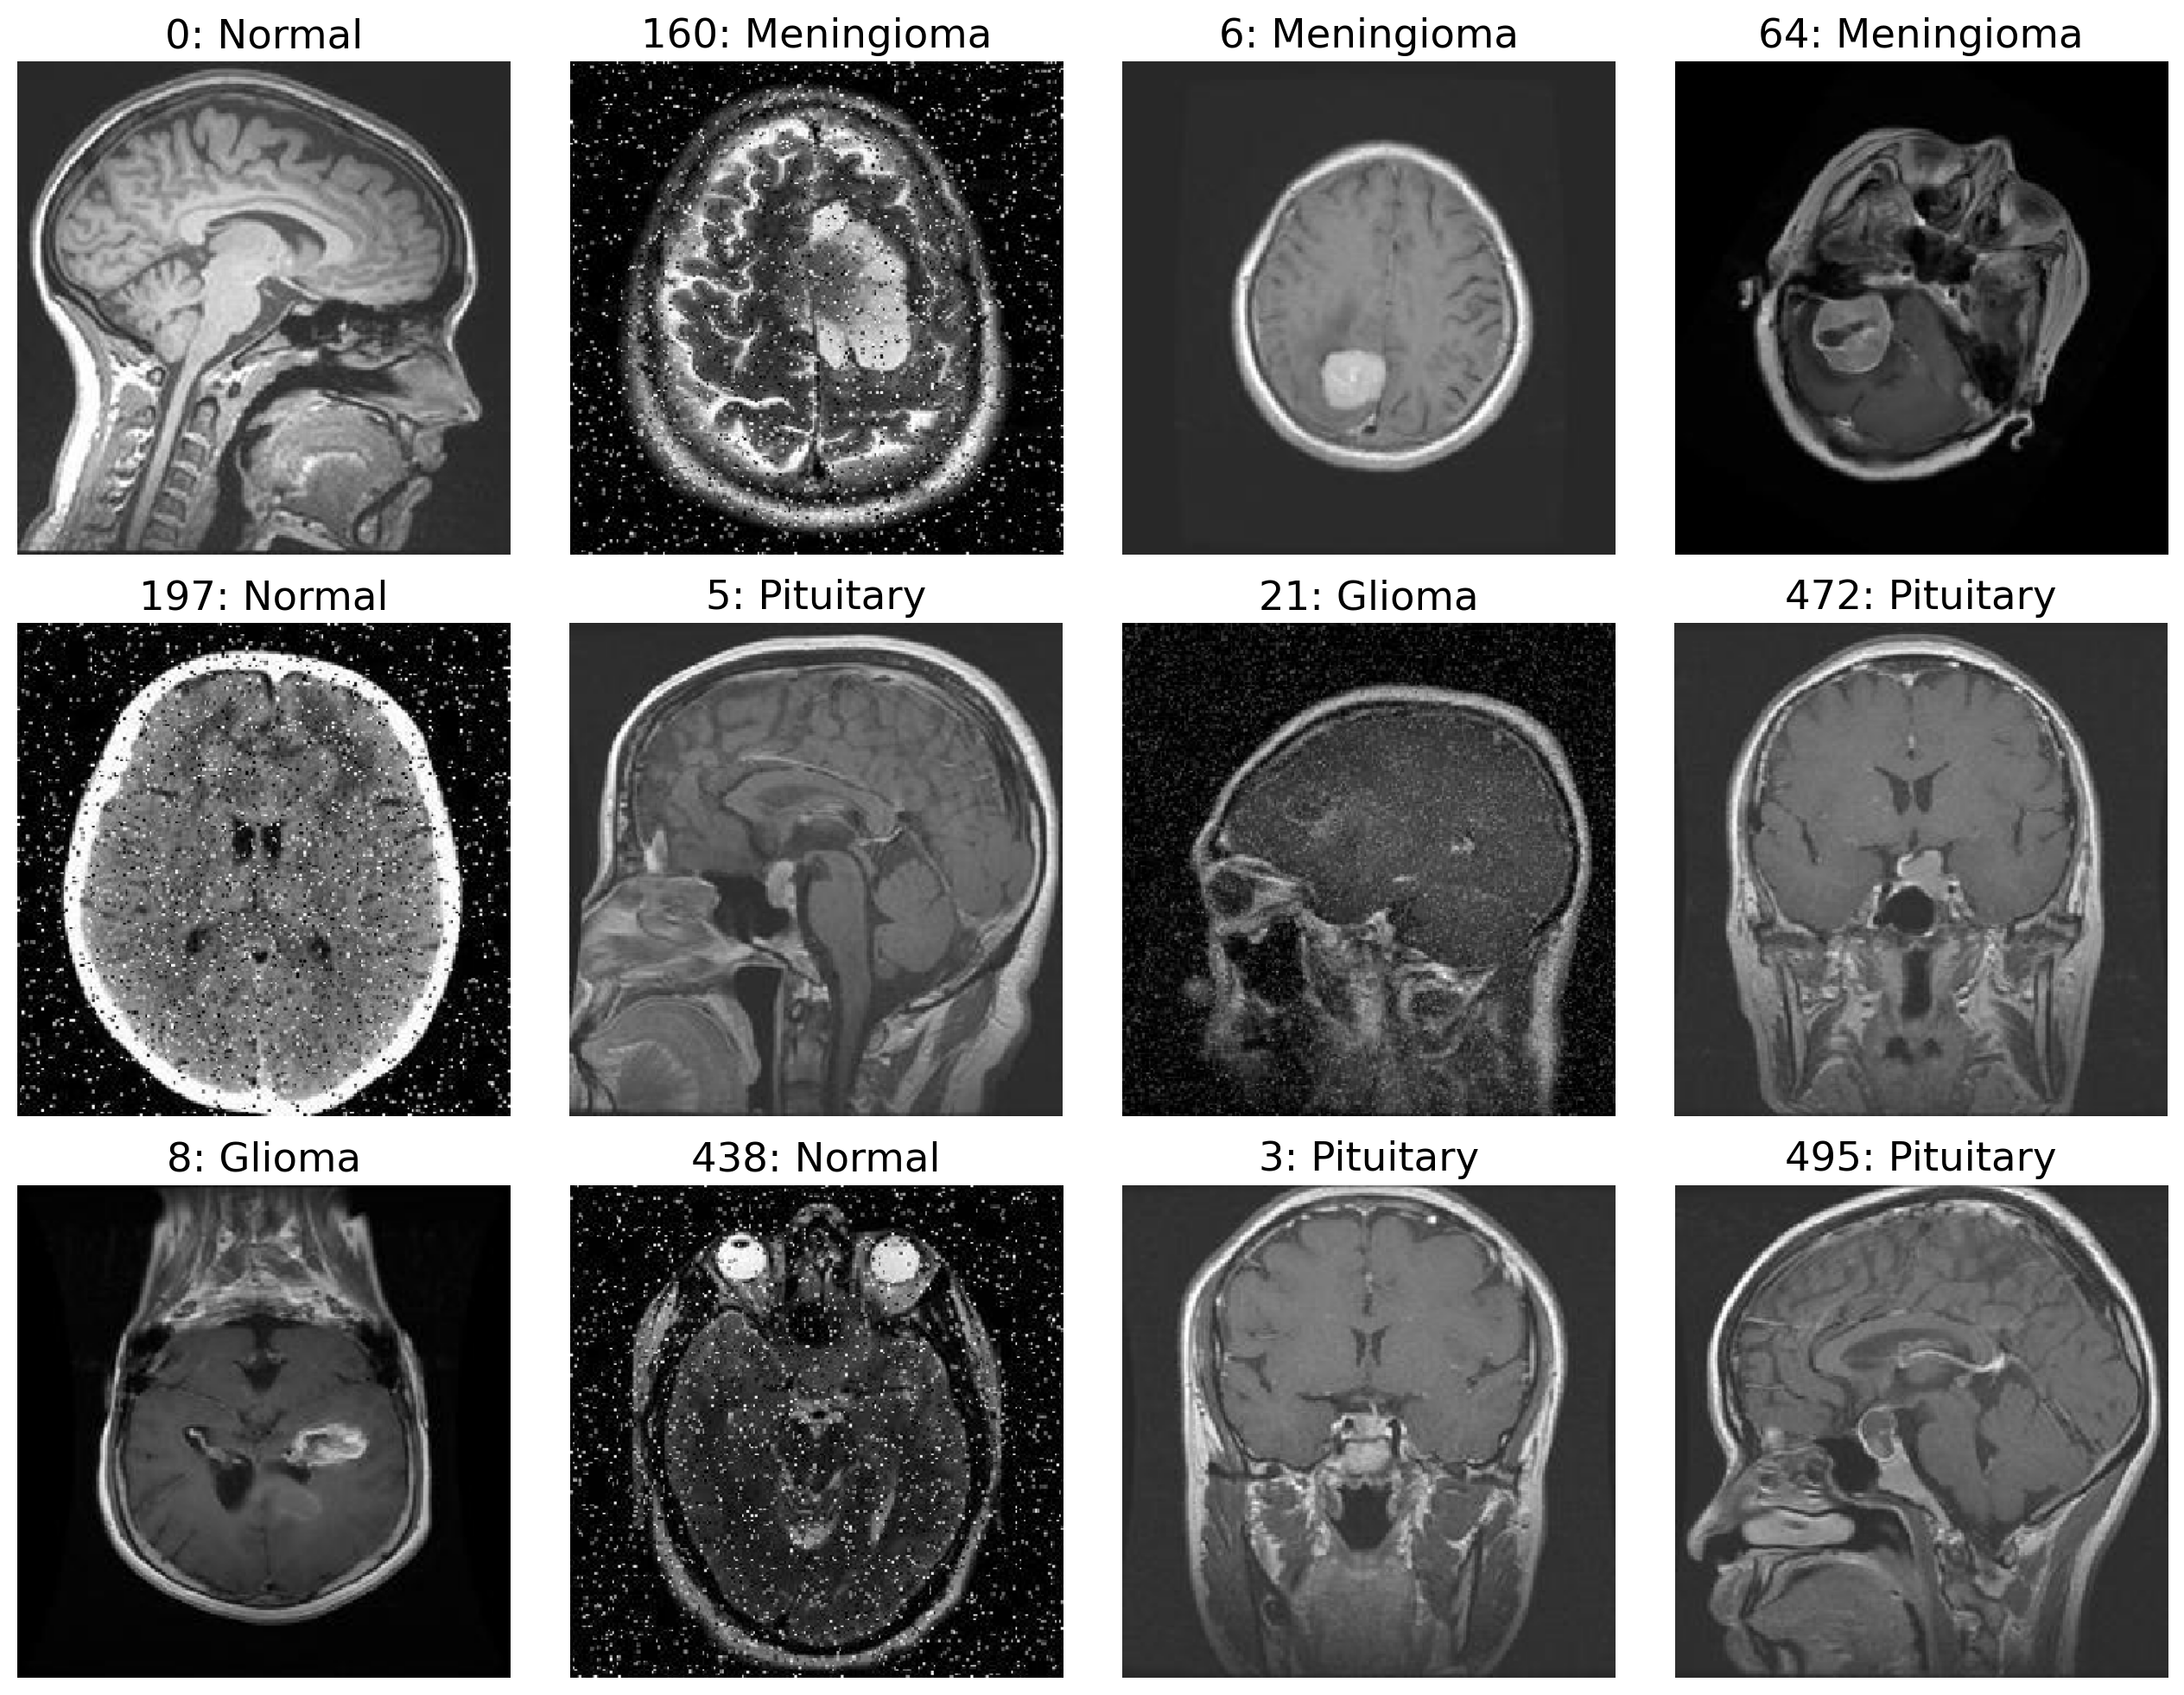

In [22]:
# Four different data classification images, from three different angles (images are independent)
show_images(train_paths, 
            train_labels, 
            index_list=[0, 160, 6, 64,
                        197, 5, 21, 472,
                        8, 438, 3, 495], 
            im_size=350, 
            figsize=(13,10),
            save=SAVE)

Data augmentation is already applied.

In [23]:
# Image shape: height, width, RBG
image_size = (150, 150)
image_shape = (image_size[0], image_size[1], 1)

# Training parameters
epochs = 20
batch_size = 150

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

Image shape: (150, 150, 1)
Epochs: 20
Batch size: 150


In [24]:
def img_preprocessing(image_path, label_encoded):
    # Read and decode the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Convert to grayscale
    img = tf.image.rgb_to_grayscale(img)
    
    # Resize and normalize the image
    img = tf.image.resize(img, size=(150, 150))
    img = img / 255.0
    
    return img, tf.one_hot(label_encoded, depth=N_TYPES)

# Creating dataset loaders with label indices
train_loader = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['label_encoded']))
train_dataset = (train_loader.map(img_preprocessing
                                 ).batch(batch_size).shuffle(train_df['path'].shape[0]).prefetch(batch_size))

test_loader = tf.data.Dataset.from_tensor_slices((test_df['path'], test_df['label_encoded']))
test_dataset = (test_loader.map(img_preprocessing
                               ).batch(batch_size).shuffle(test_df['path'].shape[0]).prefetch(batch_size))


***
<a name='CNN'>
    
# 6 <span style='color:blue'>|</span> CNN Model

In [25]:
# Define the model architecture
model = models.Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3))) #

# Convolutional layer 4
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(Flatten())

# Full connect layers
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5, seed=SEED))
model.add(Dense(N_TYPES, activation="softmax"))

model.summary()


optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.87, beta_2=0.9995)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 147, 147, 32)      544       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [26]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 26.7 MB/s eta 0:00:0000:01


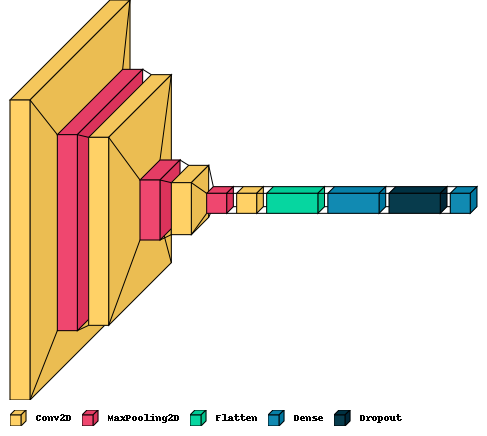

In [27]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)

In [28]:
# addition of callbacks
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=6, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)
model_cp = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_accuracy')

# Training the model
history = model.fit(train_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=test_dataset,
                    callbacks=[model_es, model_rlr, model_cp])

Epoch 1/20
94/94 [==============================] - 251s 2s/step - loss: 1.0600 - accuracy: 0.5267 - val_loss: 0.8093 - val_accuracy: 0.6655 - lr: 0.0010
Epoch 2/20
94/94 [==============================] - 234s 2s/step - loss: 0.7266 - accuracy: 0.6992 - val_loss: 0.5799 - val_accuracy: 0.7643 - lr: 0.0010
Epoch 3/20
94/94 [==============================] - 234s 2s/step - loss: 0.5175 - accuracy: 0.7975 - val_loss: 0.4288 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 4/20
94/94 [==============================] - 238s 2s/step - loss: 0.3495 - accuracy: 0.8688 - val_loss: 0.3338 - val_accuracy: 0.8806 - lr: 0.0010
Epoch 5/20
94/94 [==============================] - 241s 2s/step - loss: 0.2440 - accuracy: 0.9112 - val_loss: 0.2891 - val_accuracy: 0.8977 - lr: 0.0010
Epoch 6/20
94/94 [==============================] - 238s 2s/step - loss: 0.1706 - accuracy: 0.9387 - val_loss: 0.2131 - val_accuracy: 0.9258 - lr: 0.0010
Epoch 7/20
94/94 [==============================] - 235s 2s/step - loss: 0.1

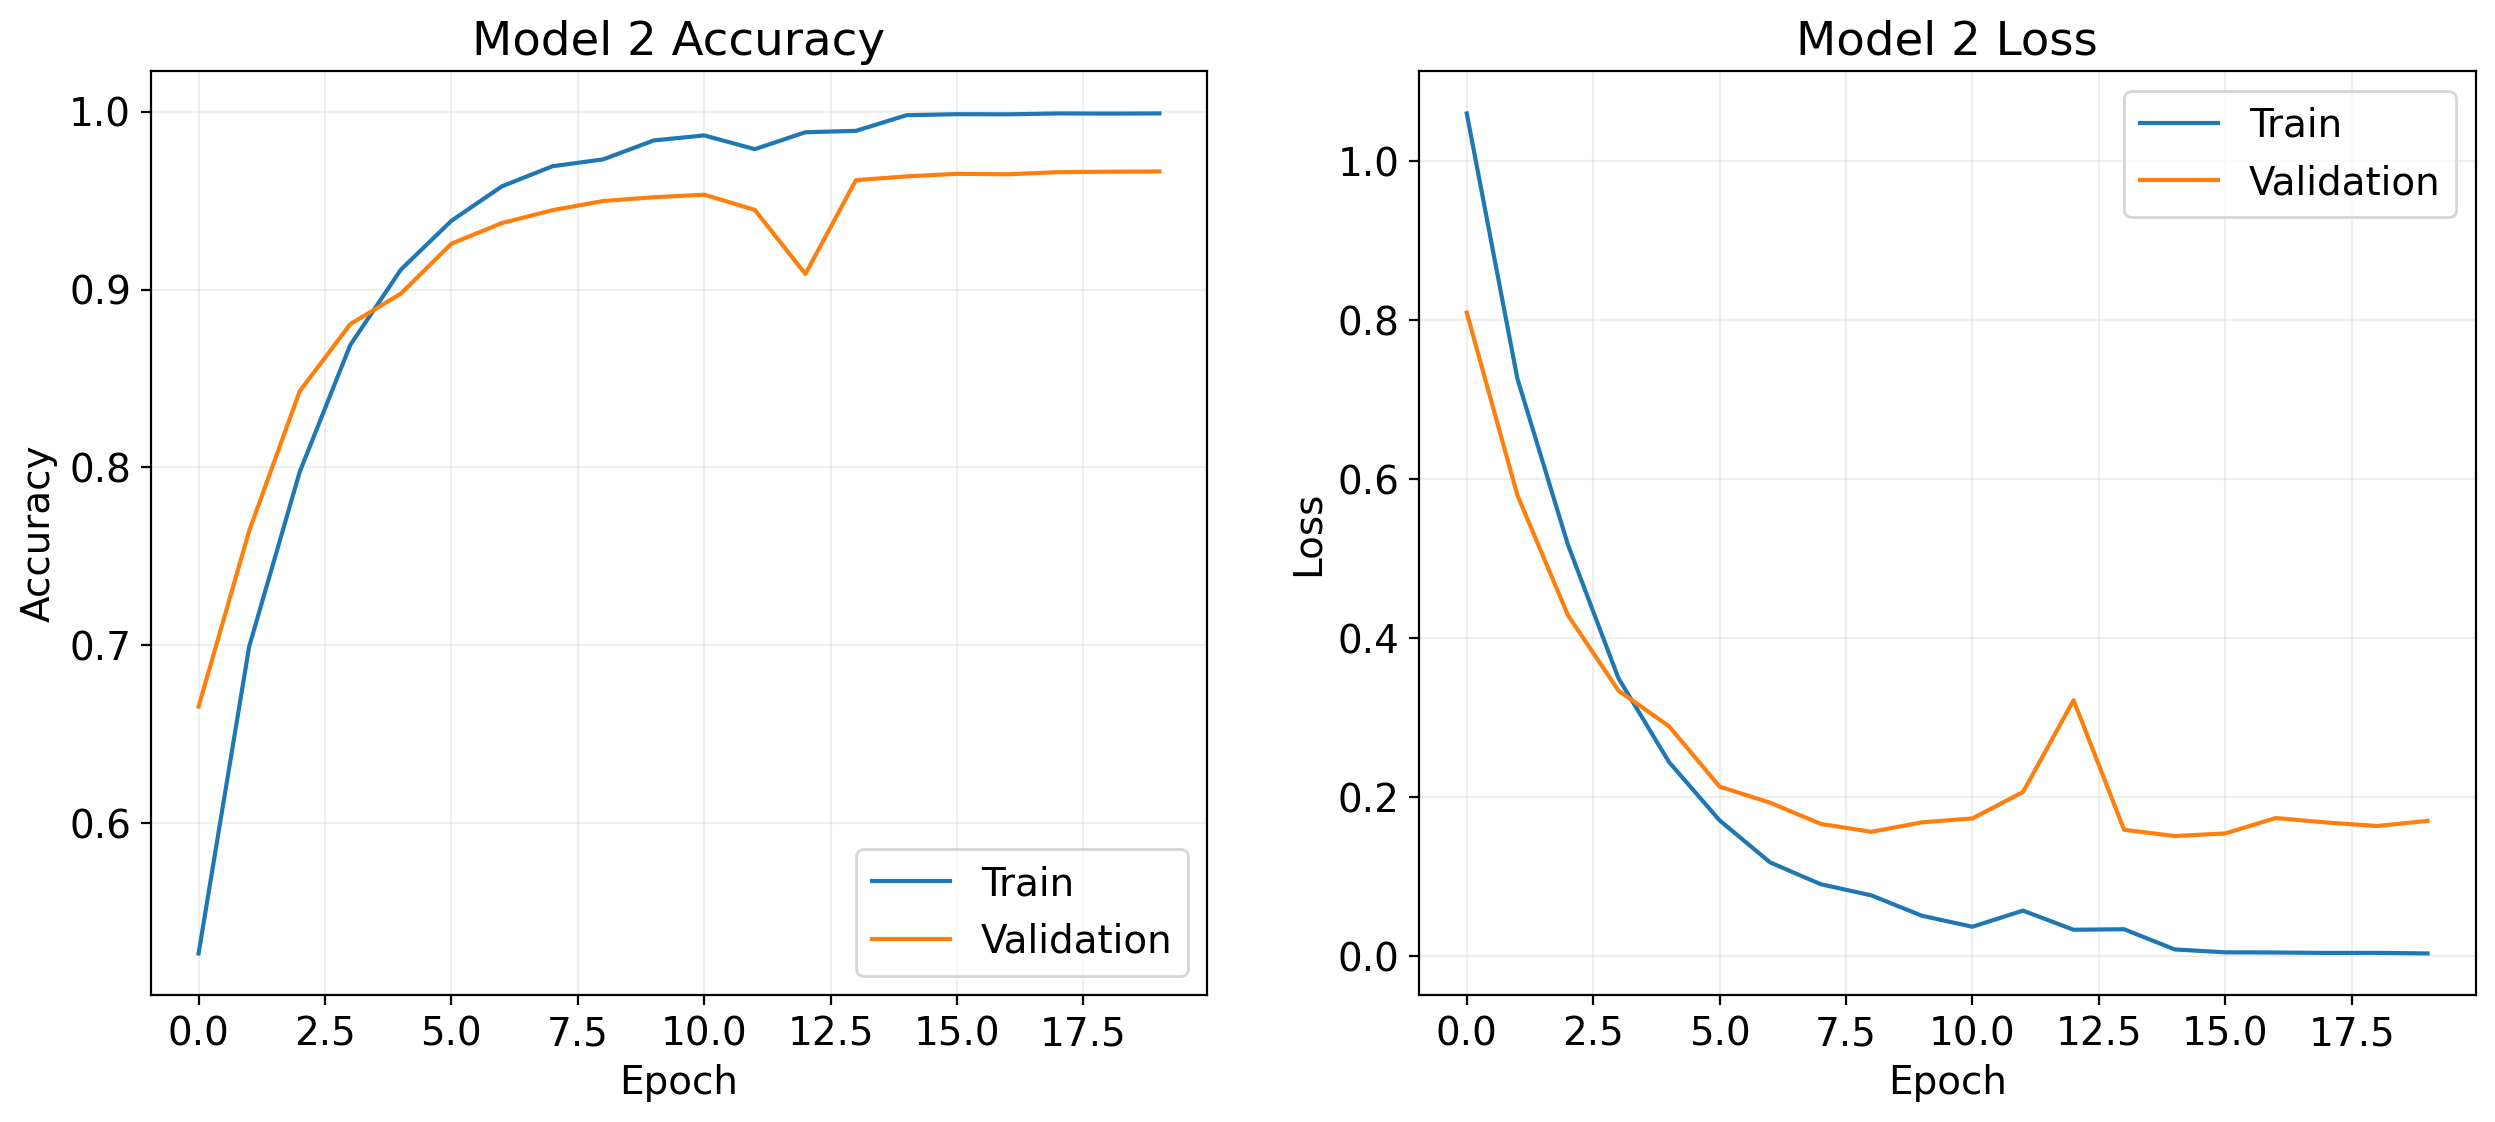

In [29]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

In [30]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/kaggle/working/best_weights.h5')

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

def generate_confusion_matrix(model, test_dataset, class_names):
    
    from sklearn.metrics import classification_report

    # Assuming test_dataset is a TensorFlow dataset
    true_labels = []
    predicted_labels = []

    for batch in test_dataset:
        images, labels = batch

        # Predict classes for the batch
        predictions = model.predict(images, verbose=False)
        predicted_classes = np.argmax(predictions, axis=1)

        # Convert one-hot encoded labels to class indices
        true_classes = np.argmax(labels, axis=1)

        true_labels.extend(true_classes)
        predicted_labels.extend(predicted_classes)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Print accuracy metrics using classification_report
    class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print("Classification Report:\n", class_report)
    
    return cm

In [32]:
cm = generate_confusion_matrix(model, test_dataset, list(tumor_classes.keys()))

Classification Report:
               precision    recall  f1-score   support

      Normal       0.97      0.96      0.97      1062
      Glioma       0.97      0.95      0.96      2176
  Meningioma       0.95      0.97      0.96      2242
   Pituitary       0.98      0.98      0.98      2105

    accuracy                           0.97      7585
   macro avg       0.97      0.97      0.97      7585
weighted avg       0.97      0.97      0.97      7585



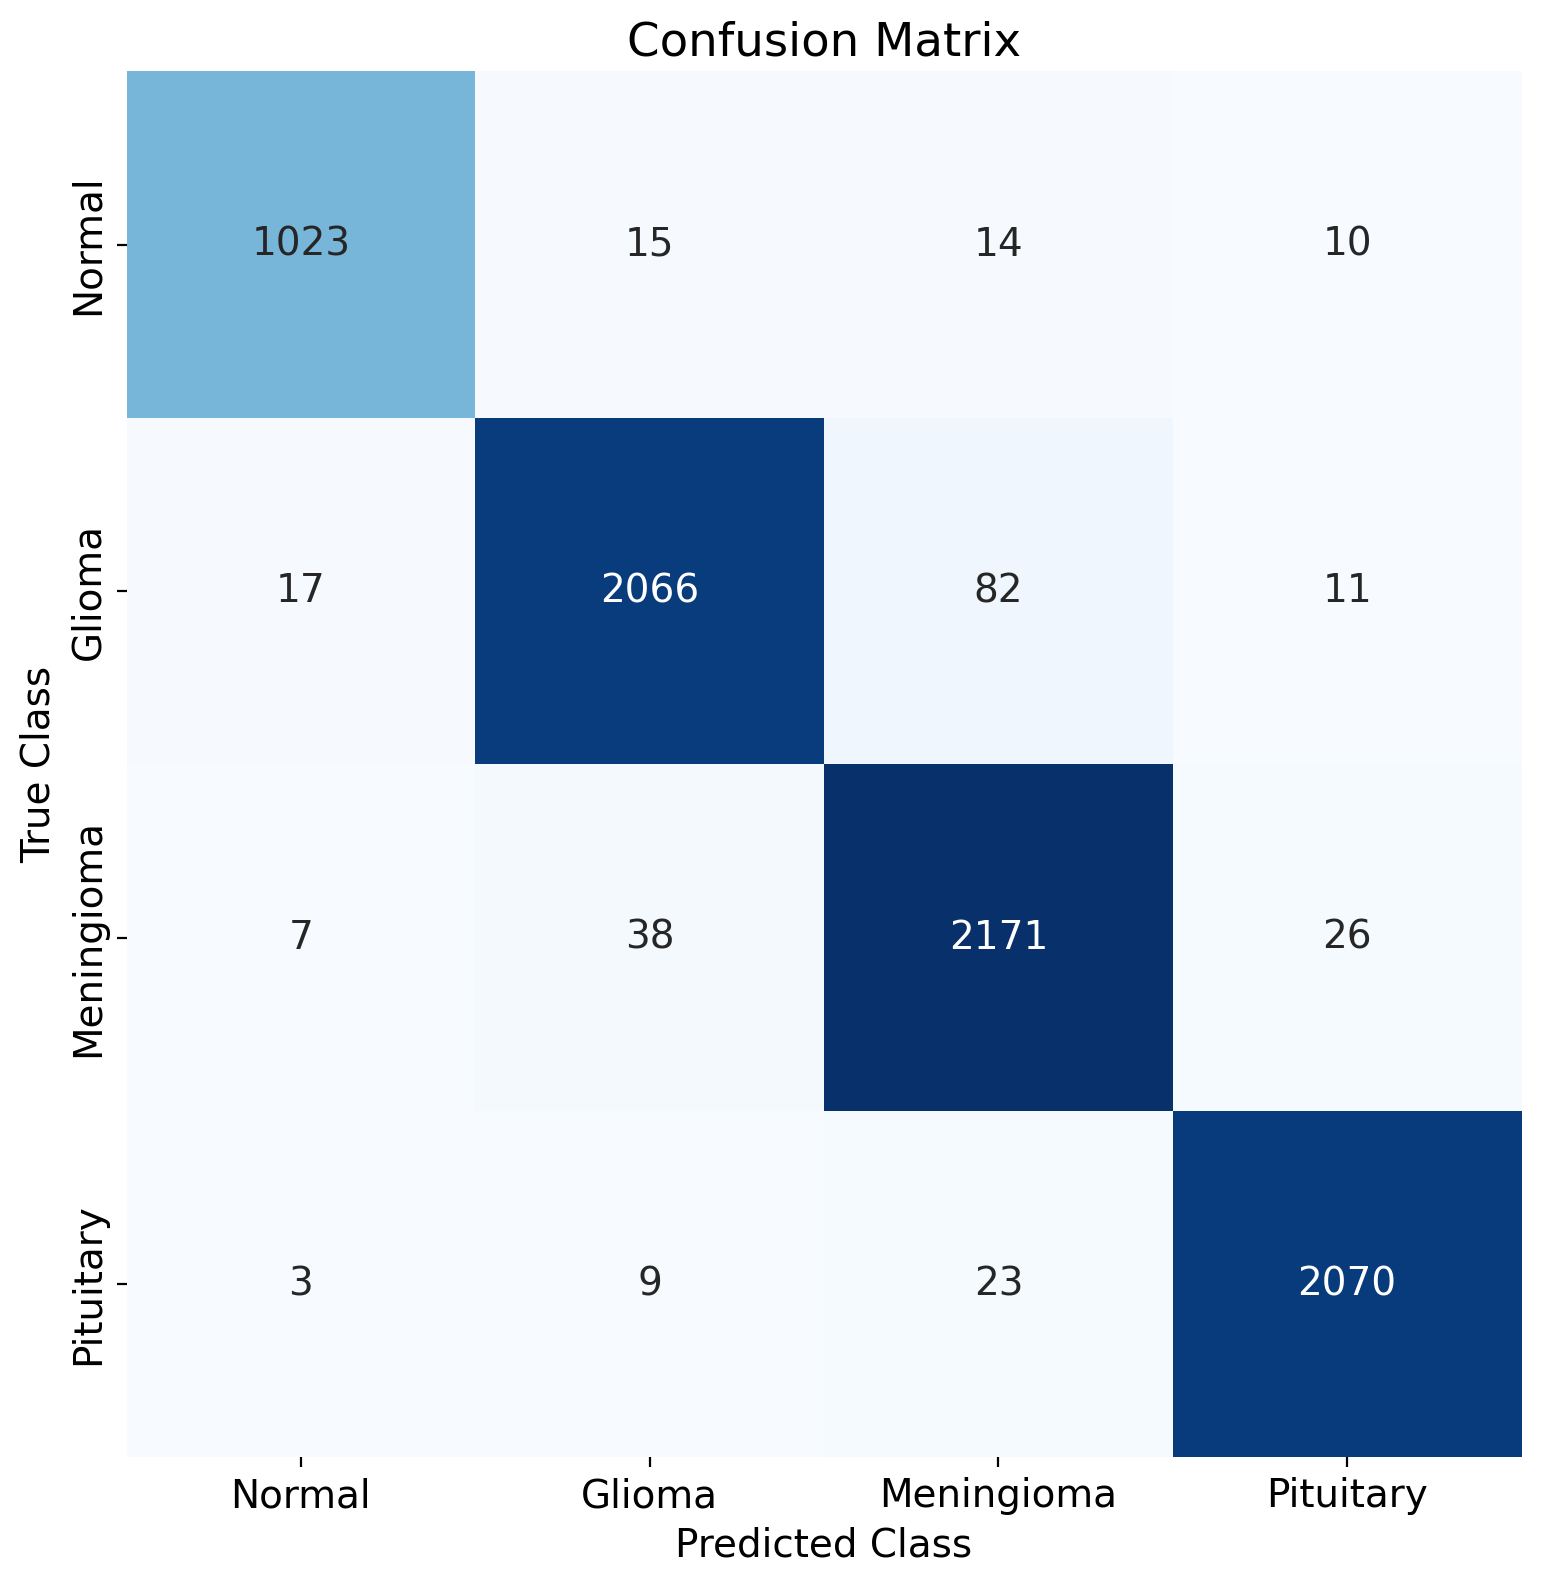

In [33]:
plot_confusion_matrix(cm, list(tumor_classes.keys()))

In [34]:
# channnel map plot
def plot_channel_activation_maps(model, image, images_per_row=16, N=8, save=False):
    """
    Function to visualize how the first N layers of the model observe the input image.

    Parameters:
        model (tensorflow.keras.models.Model): The Keras model for which to visualize the activation maps.
        image (numpy.ndarray): The input image for which to generate activation maps.
        images_per_row (int): Number of activation maps to display per row in the grid.
        N (int): Number of layers to visualize.
        save (bool): If True, save the plots as PDF files.

    Returns:
        None
    """
    from tensorflow.keras.models import Model
    
    # Create a sub-model that outputs activations for the first N layers
    activation_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers[:N]])
    activations = activation_model.predict(image)

    # Get the names of the layers for labeling the plots
    layer_names = [layer.name for layer in model.layers[:N]]

    # Visualize the feature maps for each layer
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]
        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]
        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                epsilon = 1e-8  # A small epsilon value to avoid division by zero
                channel_std = channel_image.std() + epsilon
                channel_image /= channel_std
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size,
                             row * size: (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

        if save:
            plt.savefig(f'plot_channel_activation_maps_{layer_name}.pdf')

    plt.show()

In [35]:
path, label = test_df.iloc[0, 0], test_df.iloc[0, 1]
print(path, label)

/kaggle/input/brain-tumors-dataset/Data/Tumor/glioma_tumor/G_99_HF_.jpg Glioma


x reshaped: (1, 150, 150, 1)
Class name of the first image: Glioma


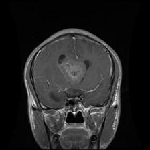

In [36]:
# getting image to test output
im = load_img(path, target_size=(150, 150), color_mode="grayscale")
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
image_tensor = np.expand_dims(im, axis=0)
print(f'x reshaped: {image_tensor.shape}')

# normilzation tensor
image_tensor /= np.max(image_tensor) # ~ np.max(img_tensor)

# Display the class name
print(f"Class name of the first image: {label}")
array_to_img(im)

1/1 [==============================] - 0s 82ms/step


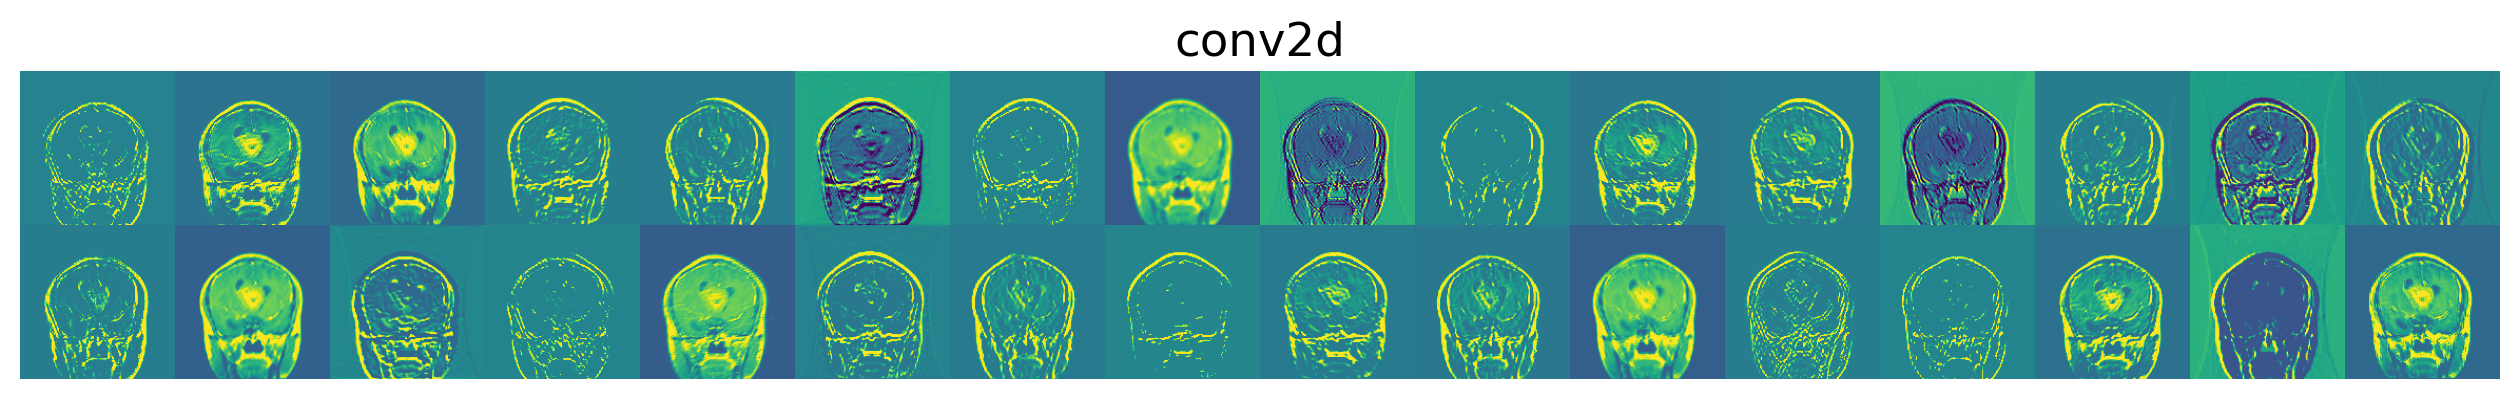

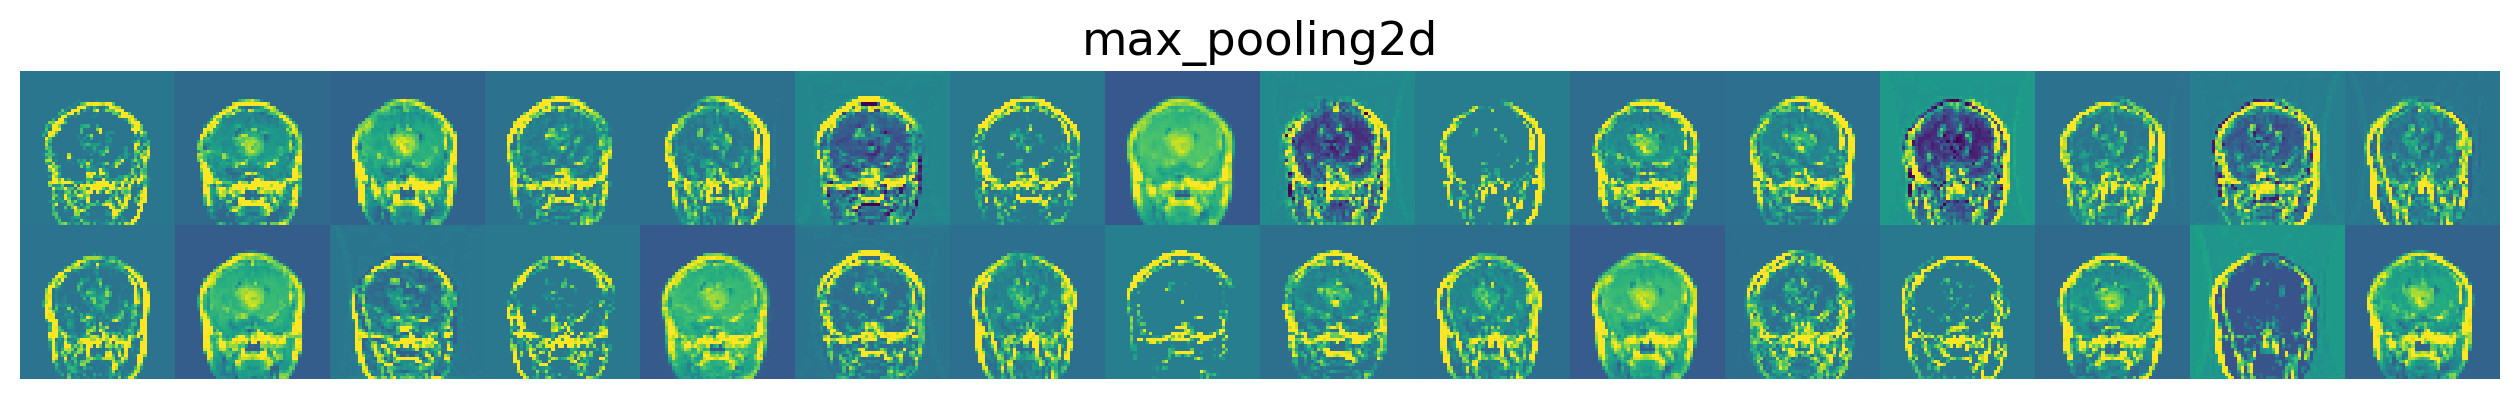

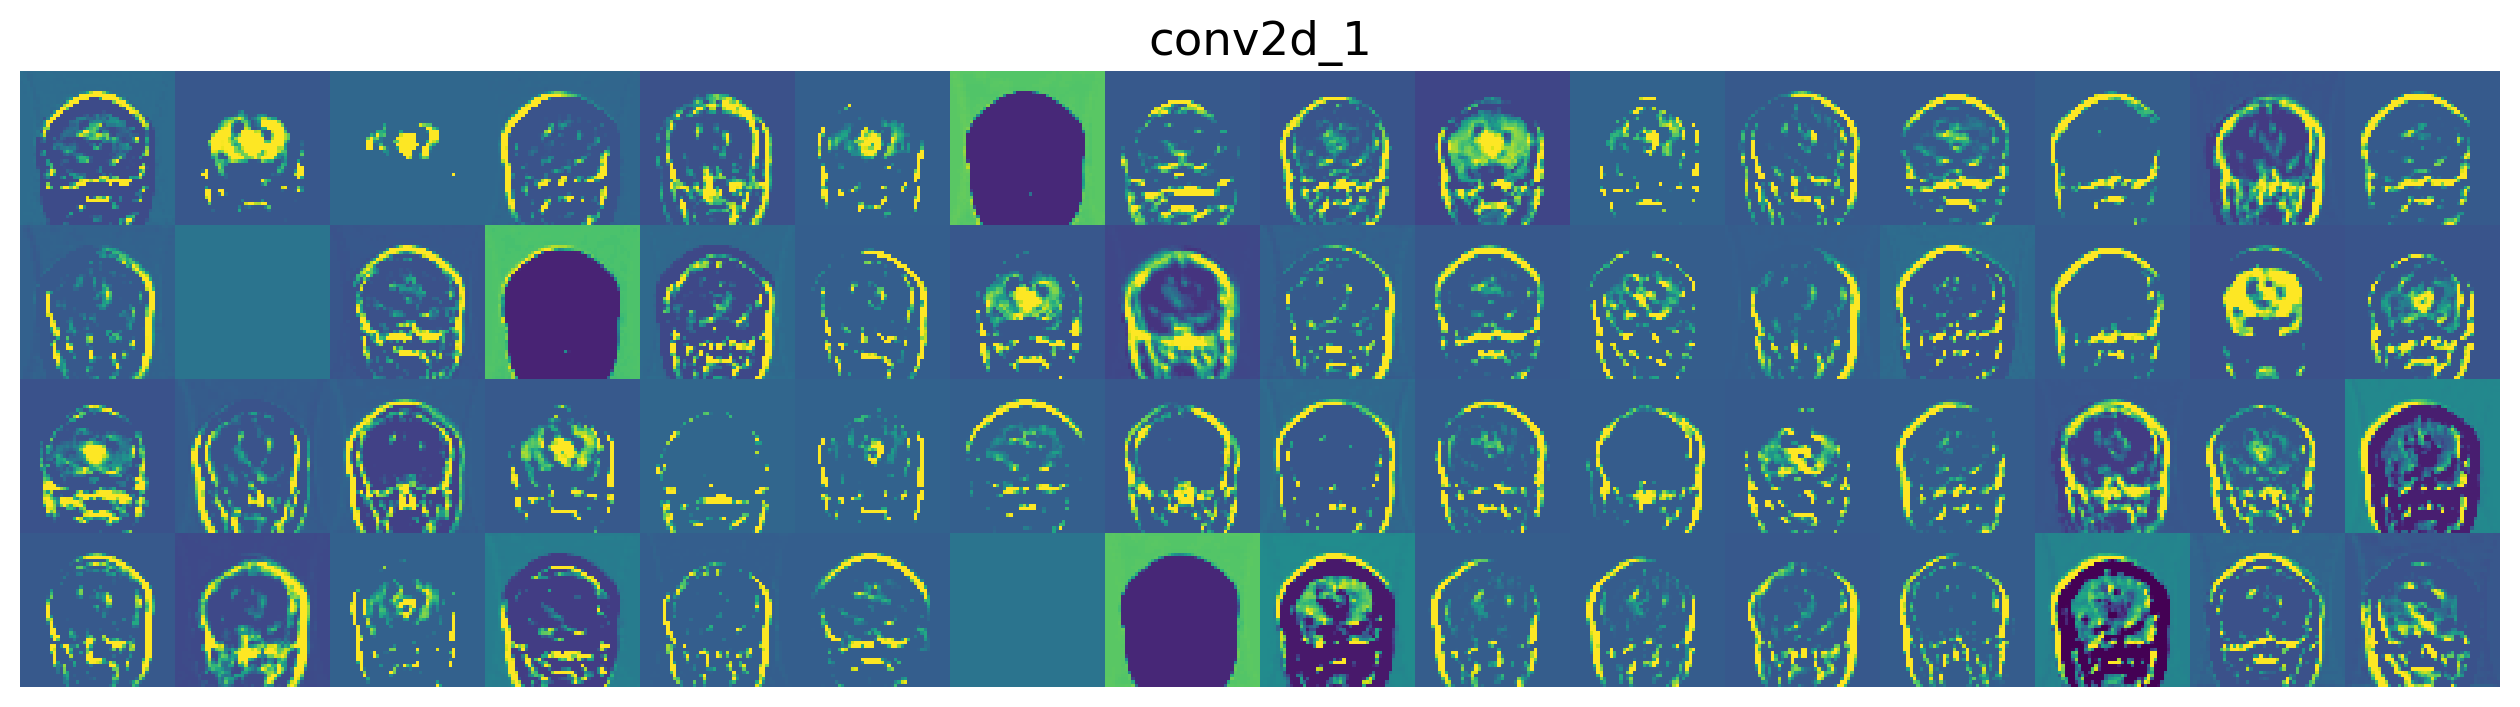

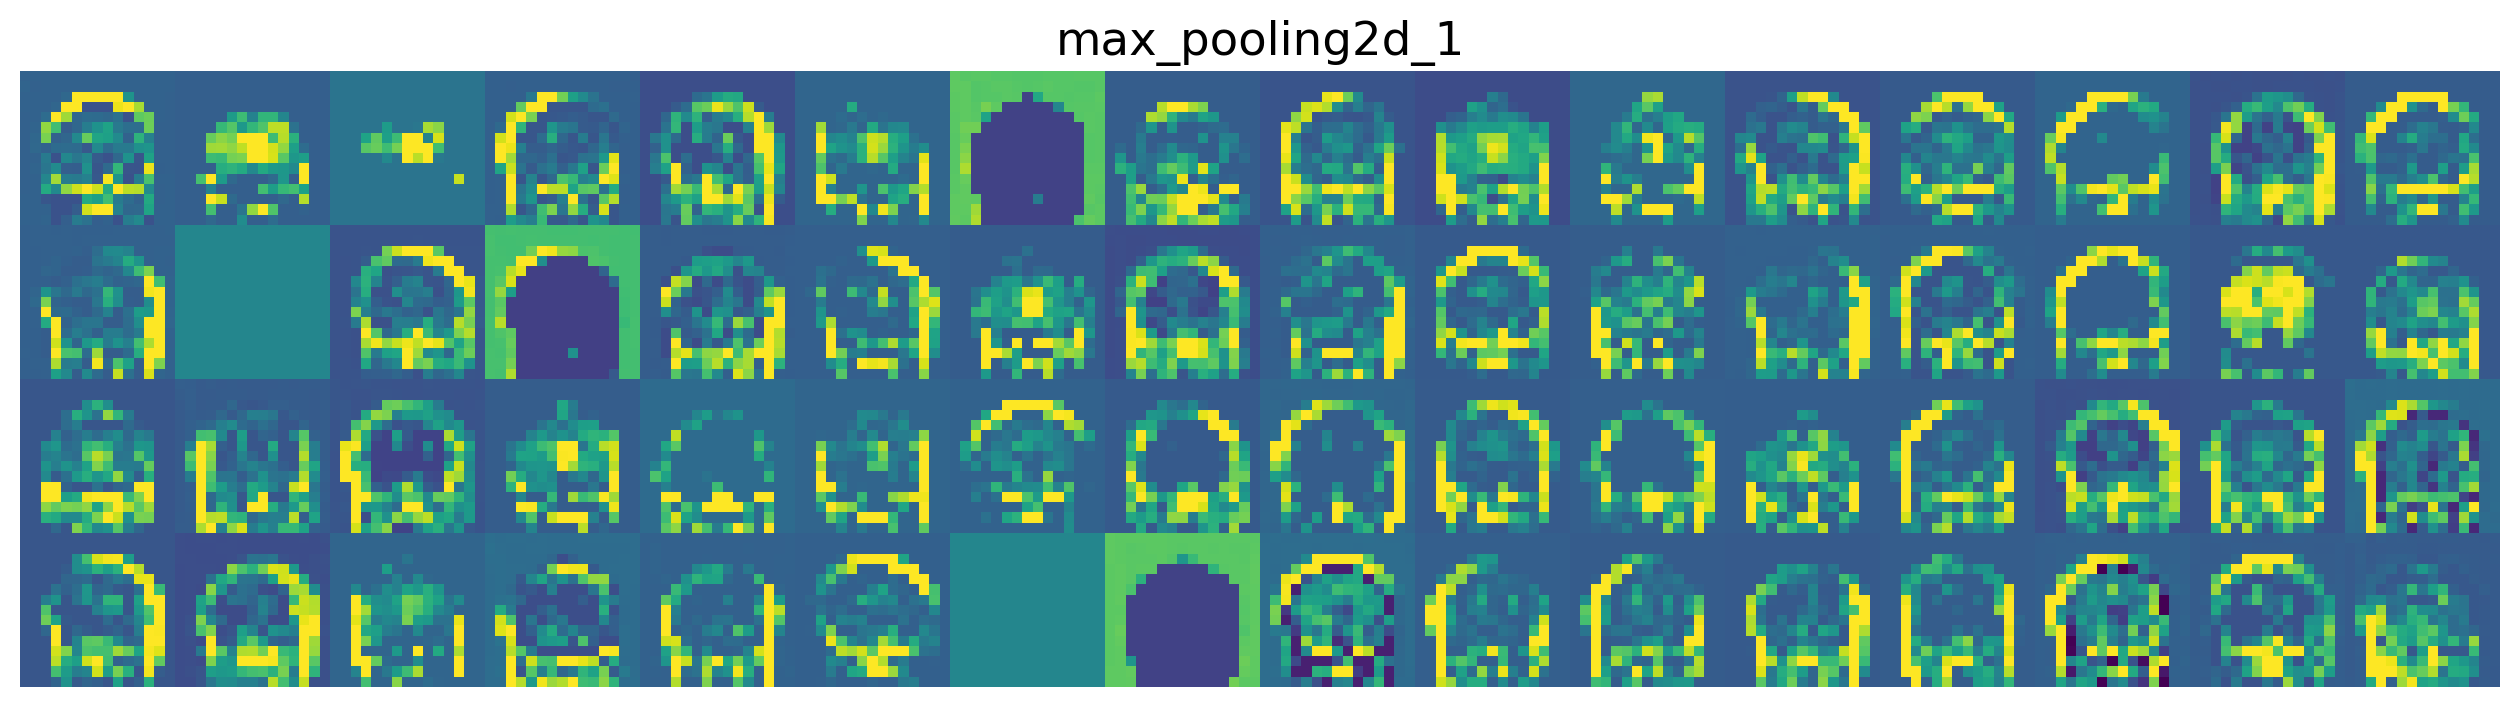

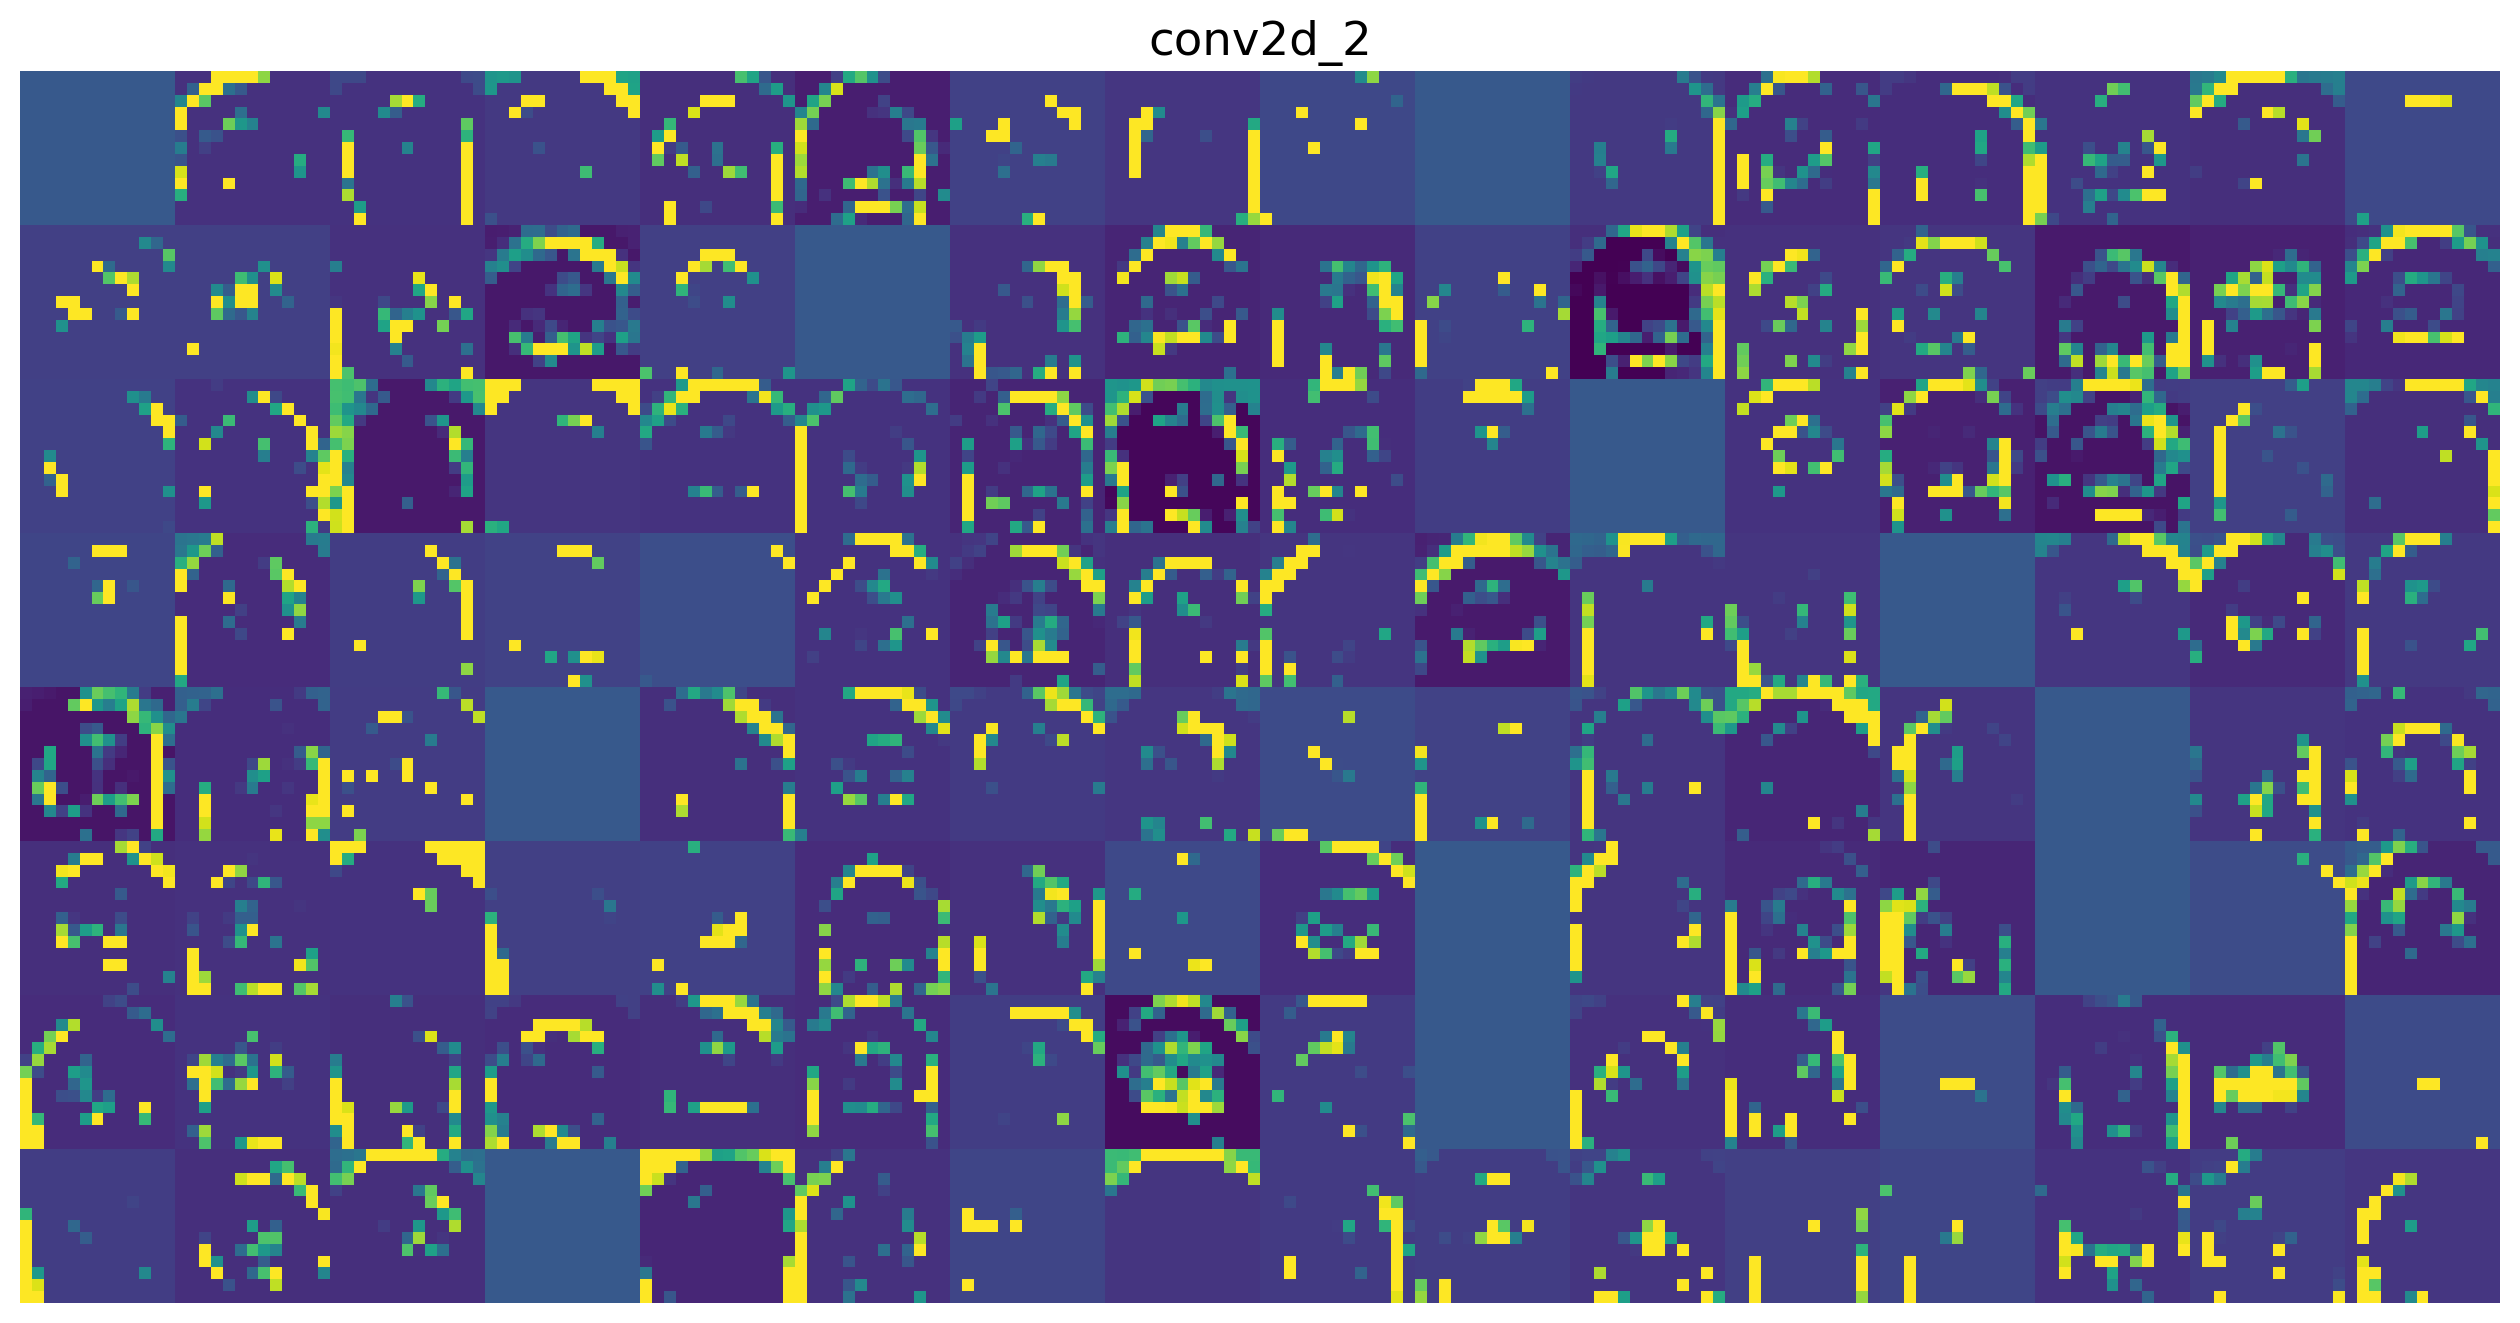

In [37]:
plot_channel_activation_maps(model=model, image=image_tensor, N=5, save=False)

In [38]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the path to the image you want to classify
image_path = '/kaggle/input/newerr12/M_1_BR_.jpg'  # Replace with the actual image path

# Load the image and preprocess it
img = load_img(image_path, target_size=(150, 150), color_mode="grayscale")
img = img_to_array(img)
image_tensor = np.expand_dims(img, axis=0)
image_tensor /= 255.0  # Normalize the image (if it's not already normalized)

# Load the trained model
model = tf.keras.models.load_model('best_weights.h5')  # Replace with the path to your model

# Make a prediction with the loaded model
predictions = model.predict(image_tensor)

# Map the prediction to a class label
class_labels = ['Normal', 'Glioma', 'Meningioma', 'Pituitary']  # Replace with your class labels
predicted_class = class_labels[np.argmax(predictions)]

# Print the predicted class
print(f'Predicted class: {predicted_class}')


1/1 [==============================] - 0s 122ms/step
Predicted class: Meningioma
